In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

## Load the Dataset

In [4]:
df = pd.read_csv("../data/Titanic.csv")
df.head()

,Row Number,Passenger Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Life Boat,Survived
0,1,First,"Allen, Miss. Elisabeth Walton",Female,29,0,0,24160,211.3375,B5,Southampton,2,Yes
1,2,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.55,C22 C26,Southampton,11,Yes
2,3,First,"Allison, Miss. Helen Loraine",Female,2,1,2,113781,151.55,C22 C26,Southampton,?,No
3,4,First,"Allison, Mr. Hudson Joshua Creighton",Male,30,1,2,113781,151.55,C22 C26,Southampton,?,No
4,5,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25,1,2,113781,151.55,C22 C26,Southampton,?,No


## Rename Features

In [5]:
# Rename some of the features to make data cleaning and further analysis easier
df.rename(columns={'Port of Embarkation': 'Port', 'Passenger Class': 'Class', 'Passenger Fare': 'Fare', 'Cabin ': 'Cabin'}, inplace=True)

## Simple Data Inspection

In [6]:
df.shape

(1309, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Row Number      1309 non-null   int64 
 1   Class           1309 non-null   object
 2   Name            1309 non-null   object
 3   Gender          1309 non-null   object
 4   Age             1309 non-null   object
 5   No of Siblings  1309 non-null   int64 
 6   No of Parents   1309 non-null   int64 
 7   Ticket Number   1309 non-null   object
 8   Fare            1309 non-null   object
 9   Cabin           1309 non-null   object
 10  Port            1309 non-null   object
 11  Life Boat       1309 non-null   object
 12  Survived        1309 non-null   object
dtypes: int64(3), object(10)
memory usage: 133.1+ KB


In [8]:
df.describe(include='all')

,Row Number,Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Fare,Cabin,Port,Life Boat,Survived
count,1309.000000,1309,1309,1309,1309,1309.000000,1309.000000,1309,1309,1309,1309,1309,1309
unique,NaN,3,1307,2,99,NaN,NaN,929,282,187,4,28,2
top,NaN,Third,"Connolly, Miss. Kate",Male,?,NaN,NaN,CA. 2343,8.05,?,Southampton,?,No
freq,NaN,709,2,843,263,NaN,NaN,11,60,1014,914,823,809
mean,655.000000,NaN,NaN,NaN,NaN,0.498854,0.385027,NaN,NaN,NaN,NaN,NaN,NaN
std,378.020061,NaN,NaN,NaN,NaN,1.041658,0.865560,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,328.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,655.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,982.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Note the issues with the data :

- Age and Fare are of type object - should be numeric.
- Age, Cabin, Life Boat all show the most frequently occurring value to be '?' - Inspect the other features to determine if '?' is used in place of NaN and replace all.

## Convert Age to Numeric

In [9]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Age'] = df['Age'].round(0)

## Convert Fare to Numeric

In [10]:
df['Fare'] = pd.to_numeric(df['Fare'], errors='coerce')
df.dtypes

Row Number          int64
Class              object
Name               object
Gender             object
Age               float64
No of Siblings      int64
No of Parents       int64
Ticket Number      object
Fare              float64
Cabin              object
Port               object
Life Boat          object
Survived           object
dtype: object

## Loop through the categorical features and inspect the possible values

In [11]:
cat_feats = ['Class', 'Name', 'Gender', 'Ticket Number',
       'Cabin', 'Port', 'Life Boat', 'Survived']

In [12]:
for feat in cat_feats:
    print(f"********* Feature: {feat} *********\n")
    print(f"{df[feat].unique()}\n")

********* Feature: Class *********

['First' 'Second' 'Third']

********* Feature: Name *********

['Allen, Miss. Elisabeth Walton' 'Allison, Master. Hudson Trevor'
 'Allison, Miss. Helen Loraine' ... 'Zakarian, Mr. Mapriededer'
 'Zakarian, Mr. Ortin' 'Zimmerman, Mr. Leo']

********* Feature: Gender *********

['Female' 'Male']

********* Feature: Ticket Number *********

['24160' '113781' '19952' '13502' '112050' '11769' 'PC 17609' 'PC 17757'
 'PC 17477' '19877' '27042' 'PC 17318' 'PC 17558' '11813' '13050' '11751'
 '111369' 'PC 17483' '13905' '11967' 'PC 17760' '110564' '113784' '112277'
 '36928' '113783' '110489' 'PC 17608' '113505' '111427' '113054'
 'PC 17591' '112379' 'PC 17610' '16966' '113050' '113798' 'PC 17476'
 'PC 17606' 'PC 17755' '695' '113059' '113760' '19924' '17770'
 'W.E.P. 5734' '113806' '110152' 'PC 17594' '112051' '13508' '110465'
 '5727' 'PC 17756' '11770' '113791' 'WE/P 5735' '112901' 'PC 17599'
 '113055' '113804' 'F.C. 12750' '17474' '33638' 'PC 17761' '11755'
 

## Replace "?" with NAs

In [13]:
df[df['Port'] == '?']

,Row Number,Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Fare,Cabin,Port,Life Boat,Survived
168,169,First,"Icard, Miss. Amelie",Female,38.0,0,0,113572,80.0,B28,?,6,Yes
284,285,First,"Stone, Mrs. George Nelson (Martha Evelyn)",Female,62.0,0,0,113572,80.0,B28,?,6,Yes


In [14]:
df.replace('?', np.nan, inplace=True)

## Identify Missing Values

In [15]:
df.dtypes

Row Number          int64
Class              object
Name               object
Gender             object
Age               float64
No of Siblings      int64
No of Parents       int64
Ticket Number      object
Fare              float64
Cabin              object
Port               object
Life Boat          object
Survived           object
dtype: object

In [16]:
df.isna().sum()

Row Number           0
Class                0
Name                 0
Gender               0
Age                263
No of Siblings       0
No of Parents        0
Ticket Number        0
Fare                 1
Cabin             1014
Port                 2
Life Boat          823
Survived             0
dtype: int64

In [17]:
df = df[~((df['Fare'].isna()) | (df['Port'].isna()))]

In [18]:
df.columns

Index(['Row Number', 'Class', 'Name', 'Gender', 'Age', 'No of Siblings',
       'No of Parents', 'Ticket Number', 'Fare', 'Cabin', 'Port', 'Life Boat',
       'Survived'],
      dtype='object')

In [19]:
df.drop(columns=['Cabin', 'Life Boat', 'Row Number'], inplace=True)

In [20]:
df.isna().sum()

Class               0
Name                0
Gender              0
Age               263
No of Siblings      0
No of Parents       0
Ticket Number       0
Fare                0
Port                0
Survived            0
dtype: int64

In [21]:
df.loc[df['Age'].isna()]

,Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Fare,Port,Survived
15,First,"Baumann, Mr. John D",Male,NaN,0,0,PC 17318,25.9250,Southampton,No
37,First,"Bradley, Mr. George (""George Arthur Brayton"")",Male,NaN,0,0,111427,26.5500,Southampton,Yes
40,First,"Brewe, Dr. Arthur Jackson",Male,NaN,0,0,112379,39.6000,Cherbourg,No
46,First,"Cairns, Mr. Alexander",Male,NaN,0,0,113798,31.0000,Southampton,No
59,First,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",Female,NaN,0,0,17770,27.7208,Cherbourg,Yes
...,...,...,...,...,...,...,...,...,...,...
1293,Third,"Williams, Mr. Howard Hugh ""Harry""",Male,NaN,0,0,A/5 2466,8.0500,Southampton,No
1297,Third,"Wiseman, Mr. Phillippe",Male,NaN,0,0,A/4. 34244,7.2500,Southampton,No
1302,Third,"Yousif, Mr. Wazli",Male,NaN,0,0,2647,7.2250,Cherbourg,No
1303,Third,"Yousseff, Mr. Gerious",Male,NaN,0,0,2627,14.4583,Cherbourg,No


In [22]:
df.groupby(['Gender', 'Class'])['Age'].mean()

Gender  Class 
Female  First     36.839695
        Second    27.495146
        Third     22.177632
Male    First     41.026490
        Second    30.810127
        Third     25.841954
Name: Age, dtype: float64

## Impute Age using average age by gender, class, No of Siblings

In [23]:
df['Age'] = df.groupby(['Gender', 'Class'])['Age'].transform(lambda x: round(x.fillna(x.mean())))

In [24]:
df.isna().sum()

Class             0
Name              0
Gender            0
Age               0
No of Siblings    0
No of Parents     0
Ticket Number     0
Fare              0
Port              0
Survived          0
dtype: int64

## Exploratory Data Analysis

**Start by exploring Survived**

- **Class Imbalance:** We want to analyse the balance of classes. Imbalanced classes occur in classification problems when the number of observations of one class occurs significantly more than the other class(es). 
- **Chi Square Goodness of Fit:** Additionally, we would like to confirm that the differences between observed survival rates and expected survival rates are statistically significant and cannot be attributed to randomness.

### Class Imbalance 

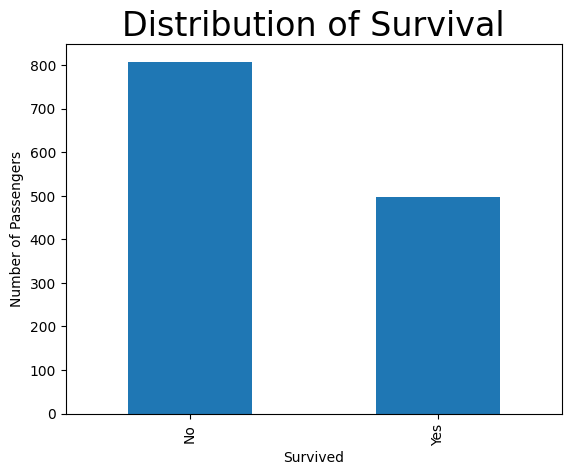

In [25]:
df['Survived'].value_counts().plot(kind='bar')

plt.title("Distribution of Survival", fontsize=24)
plt.ylabel("Number of Passengers")
plt.show()

In [26]:
survived = df['Survived'].value_counts()
survived_yes = survived.iloc[1]
survived_no = survived.iloc[0]


print(f'Number of passengers who survived: {survived_yes}')
print(f'Number of passengers who did not survive: {survived_no}')

Number of passengers who survived: 498
Number of passengers who did not survive: 808


In [27]:
class_balance_ratio = round(float(survived_no/survived_yes),2)
class_balance_ratio

1.62

In [28]:
print(f"Percent of Passengers who survived: {round(len(df[df['Survived']=='Yes']) / len(df)* 100,2)}%")

Percent of Passengers who survived: 38.13%


### Chi Square Goodness of Fit

In [29]:
observed = [float(survived_yes), float(survived_no)]
expected = [float(df['Survived'].count()/2), float(df['Survived'].count()/2)]
print(f"Expected: {expected}\nObserved: {observed}")

Expected: [653.0, 653.0]
Observed: [498.0, 808.0]


In [30]:
from scipy.stats import chisquare
chi2, p_value = chisquare(f_obs=observed, f_exp=expected)

In [31]:
print(f"Chi squared: {chi2}\n")
print(f"P value: {p_value}")

Chi squared: 73.58346094946401

P value: 9.64696289566531e-18


### **Chi Square Summary**

The Chi Square Goodness was conducted and compared to the expected survival accounts under an assumption of a 50% probability of survival. 

**Results:**

The results showed a statistically significant difference, with a chi sqaure statistic of 73.58 and a p value < 0.0001, and 1 degree of freedom.

## Univariate Analysis

### **Age:**

In [32]:
df['Age'].describe()

count    1306.000000
mean       29.307810
std        13.125106
min         0.000000
25%        22.000000
50%        26.000000
75%        36.000000
max        80.000000
Name: Age, dtype: float64

In [33]:
age_mean = round(float(df['Age'].mean()),2)
age_mode = float(df['Age'].mode().iloc[0])
age_median = float(df['Age'].median())
age_skew = df['Age'].skew()
age_kurt = df['Age'].kurt()

print(f"Mean: {age_mean}")
print(f"Median: {age_median}")
print(f"Mode: {age_mode}")
print(F"Skewness: {round(float(age_skew),2)}")
print(F"Kurtosis: {round(float(age_kurt),2)}")

Mean: 29.31
Median: 26.0
Mode: 26.0
Skewness: 0.54
Kurtosis: 0.71


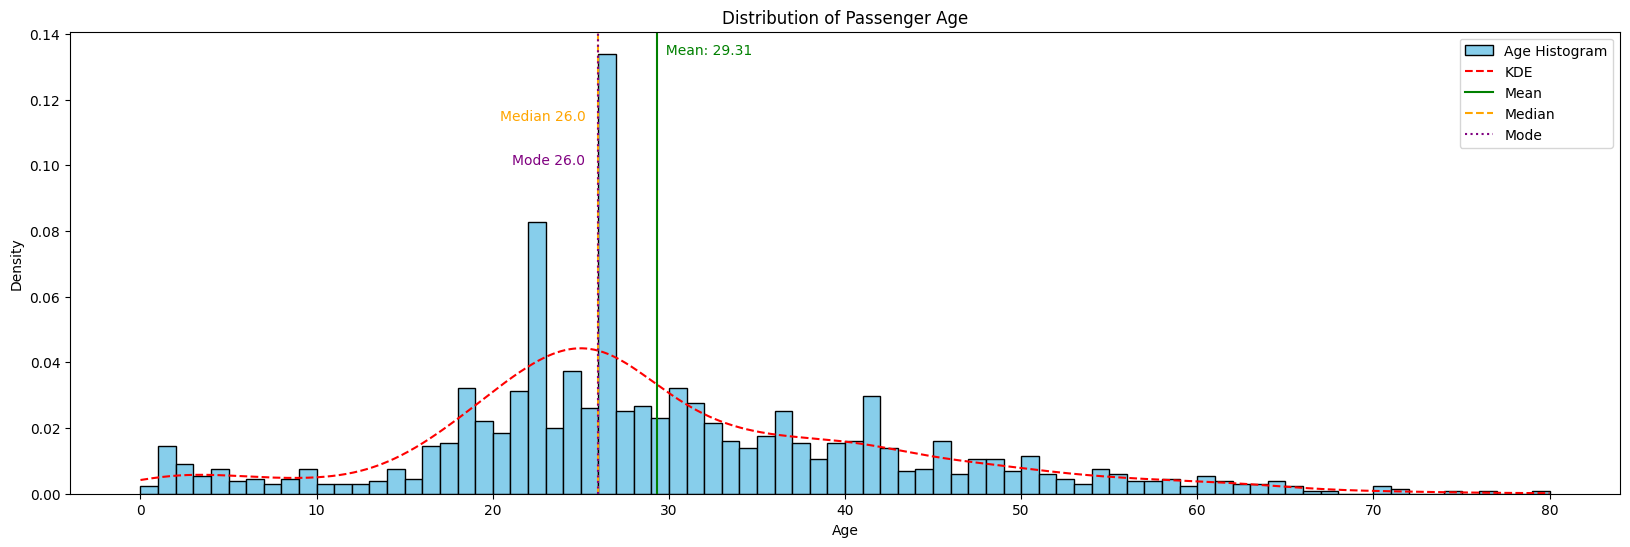

In [193]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(20,6))
ax.hist(x=df["Age"], bins=80, edgecolor='black', color='skyblue', density=True, label='Age Histogram')

kde = gaussian_kde(df['Age'])
x_vals = np.linspace(min(df['Age']), max(df['Age']), 1000)
y_vals = kde(x_vals)
ax.plot(x_vals, y_vals, color = 'red', linestyle = '--', label='KDE')

ax.axvline(age_mean, color='green', linestyle='-', label='Mean')
ax.axvline(age_median, color = 'orange', linestyle='--', label='Median')
ax.axvline(age_mode, color='purple', linestyle=':', label='Mode')

y_height = ax.get_ylim()[1] * .95
ax.text(age_mean, y_height, f'  Mean: {age_mean}', color = 'green', ha='left')
ax.text(age_median, y_height * .85, f'Median {age_median}   ', color='orange', ha='right')
ax.text(age_mode, y_height * .75, f'Mode {age_mode}   ', color='purple', ha='right')

plt.title("Distribution of Passenger Age")
plt.xlabel("Age")
plt.ylabel("Density")

plt.legend()
plt.show()

### **Fare:**

In [36]:
df['Fare'].describe()

count    1306.000000
mean       33.223956
std        51.765986
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [37]:
fare_mean = round(df['Fare'].mean(),2)
fare_median = round(df['Fare'].median(),2)
fare_mode = round(df['Fare'].mode()[0],2)
fare_skew = round(df['Fare'].skew(),2)
fare_kurt = round(df['Fare'].kurt(),2)

print(f"Mean: {fare_mean}")
print(f"Median: {fare_median}")
print(f"Mode: {fare_mode}")
print(f"Skewness: {fare_skew}")
print(f"Kurtosis: {fare_kurt}")

Mean: 33.22
Median: 14.45
Mode: 8.05
Skewness: 4.38
Kurtosis: 27.08


In [38]:
df['Fare'].isna().sum()

np.int64(0)

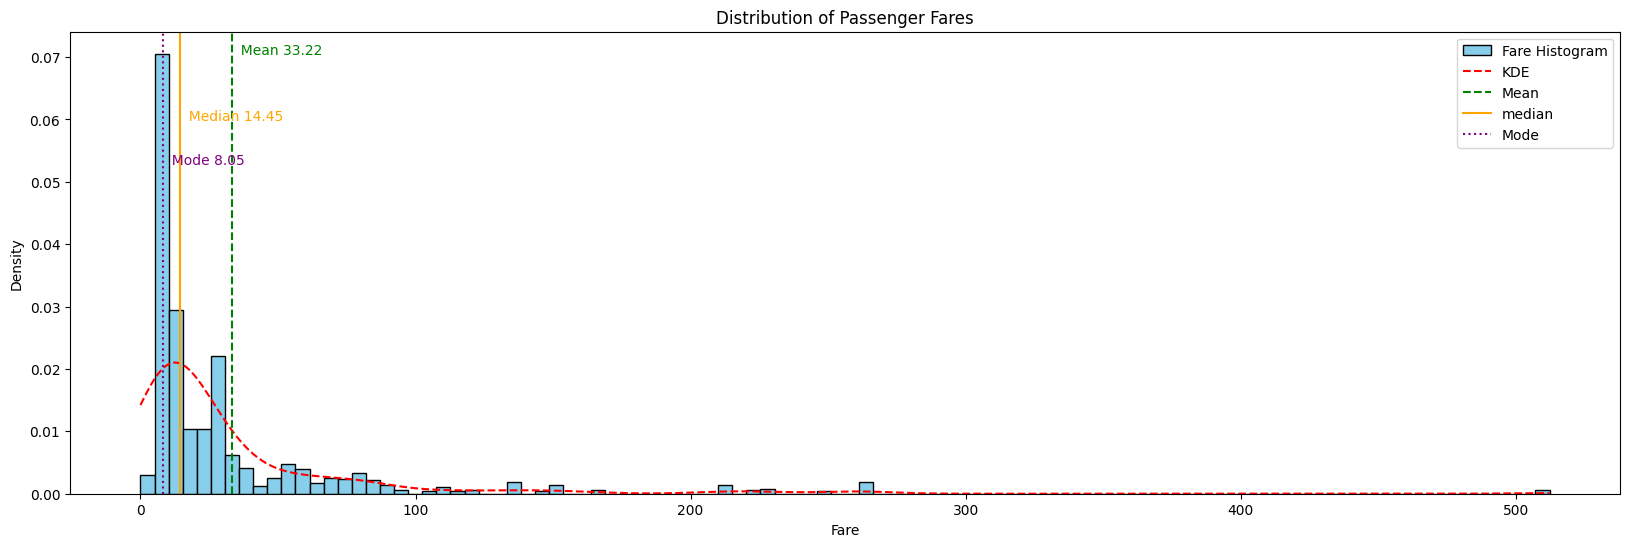

In [39]:
fig, ax = plt.subplots(figsize=(20,6))

ax.hist(x=df['Fare'], bins=100, edgecolor='black', color='skyblue', density=True, label='Fare Histogram')

kde = gaussian_kde(df['Fare'])
x_vals = np.linspace(min(df['Fare']), max(df['Fare']), 1000)
ax.plot(x_vals, kde(x_vals), color='red', linestyle='--', label='KDE')

y_height = ax.get_ylim()[1] * .95
ax.axvline(fare_mean, color='green', linestyle='--', label='Mean')
ax.text(fare_mean, y_height, f'  Mean {fare_mean}', color='green', ha='left')

ax.axvline(fare_median, color='orange', linestyle='-', label='median')
ax.text(fare_median, y_height * .85, f'  Median {fare_median}', color='orange', ha='left')

ax.axvline(fare_mode, color='purple', linestyle=':', label='Mode')
ax.text(fare_mode, y_height * .75, f'  Mode {fare_mode}', color='Purple', ha='left')

plt.title('Distribution of Passenger Fares')
plt.xlabel('Fare')
plt.ylabel('Density')

plt.legend()
plt.show()

### **No of Siblings:**

In [40]:
df['No of Siblings'].describe()

count    1306.00000
mean        0.50000
std         1.04258
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         8.00000
Name: No of Siblings, dtype: float64

In [41]:
sib_mean = df['No of Siblings'].mean()
sib_median = df['No of Siblings'].median()
sib_mode = df['No of Siblings'].mode().iloc[0]
sib_skew = df['No of Siblings'].skew()
sib_kurt = df['No of Siblings'].kurt()

print(f"Sibling Mean: {sib_mean}")
print(f"Sibling Median: {sib_median}")
print(f"Sibling Mode: {sib_mode}")
print(f"Sibling Skewness: {sib_skew}")
print(f"Sibling Kurtosis: {sib_kurt}")

Sibling Mean: 0.5
Sibling Median: 0.0
Sibling Mode: 0
Sibling Skewness: 3.8398113683848054
Sibling Kurtosis: 19.997818644918578


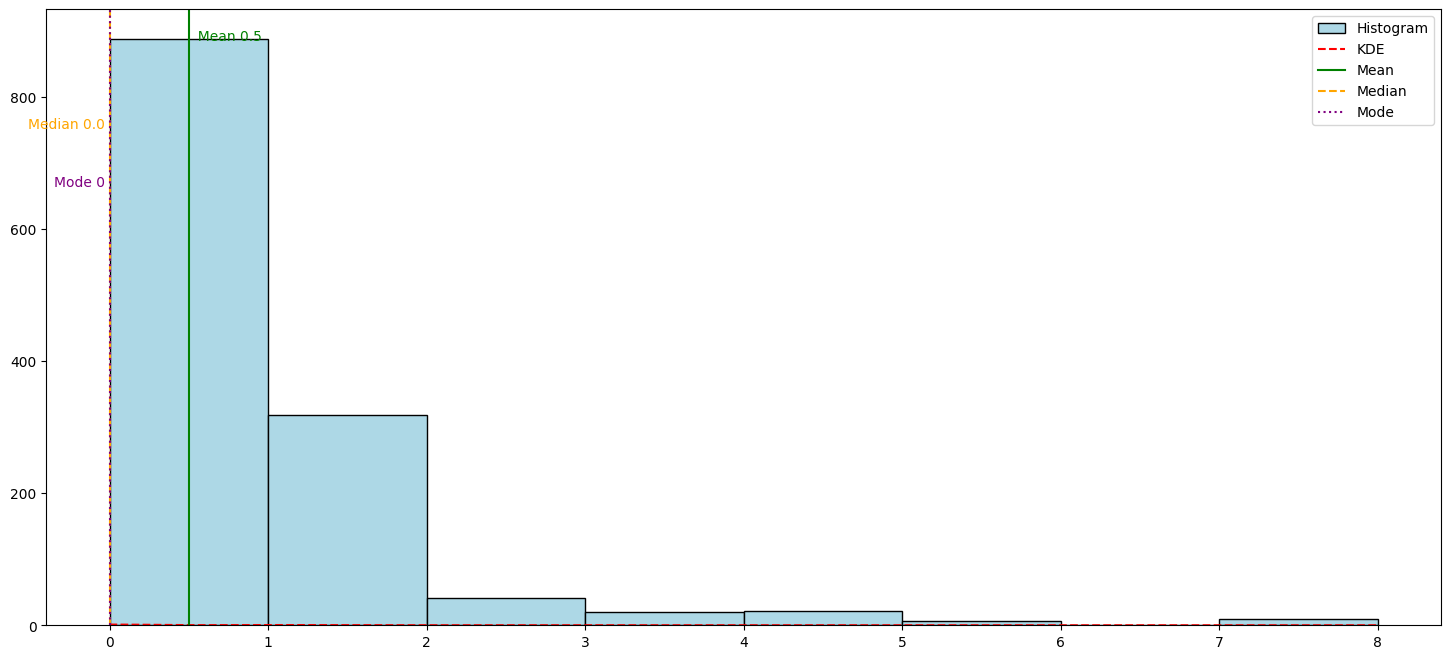

In [42]:
fig, ax = plt.subplots(figsize=(18,8))

# Draw the histogram with 30 bins
ax.hist(x=df['No of Siblings'], bins = 8, color='lightblue', edgecolor='black', label='Histogram')

# Overlay the gaussian KDE
kde = gaussian_kde(df['No of Siblings'])
x_vals = np.linspace(min(df['No of Siblings']), max(df['No of Siblings']), 1000)
y_vals = kde(x_vals)
ax.plot(x_vals, y_vals, color = 'red', linestyle = '--', label='KDE')

y_height = ax.get_ylim()[1] * .95

# Overlay the mean, median and mode values
ax.axvline(sib_mean, color = 'green', linestyle='-', label = 'Mean')
ax.text(sib_mean, y_height, f'  Mean {sib_mean}', color = 'green', ha='left')
ax.axvline(sib_median, color='orange', linestyle='--', label='Median')
ax.text(sib_median, y_height * .85, f'Median {sib_median} ', color='orange', ha='right')
ax.axvline(sib_mode, color='purple', linestyle=':', label='Mode')
ax.text(sib_mode, y_height * .75, f'Mode {sib_mode} ', color = 'purple', ha='right')

# add in titles, axis labels, and a legend before displaying
ax.legend()
plt.show()

### **No Parents:**

In [43]:
df['No of Parents'].describe()

count    1306.000000
mean        0.385911
std         0.866357
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: No of Parents, dtype: float64

In [44]:
par_mean = round(df['No of Parents'].mean(),2)
par_median = round(df['No of Parents'].median(),2)
par_mode = round(df['No of Parents'].mode()[0],2)
par_skew = df['No of Parents'].skew()
par_kurt = df['No of Parents'].kurt()

print(f'Num Parents Mean: {par_mean}')
print(f'Num Parents Median: {par_median}')
print(f'Num Parents Mode: {par_mode}')
print(f'Num Parents Skewness: {par_skew}')
print(f'Num Parents Kurtosis: {par_kurt}')

Num Parents Mean: 0.39
Num Parents Median: 0.0
Num Parents Mode: 0
Num Parents Skewness: 3.664517835664579
Num Parents Kurtosis: 21.492209239018553


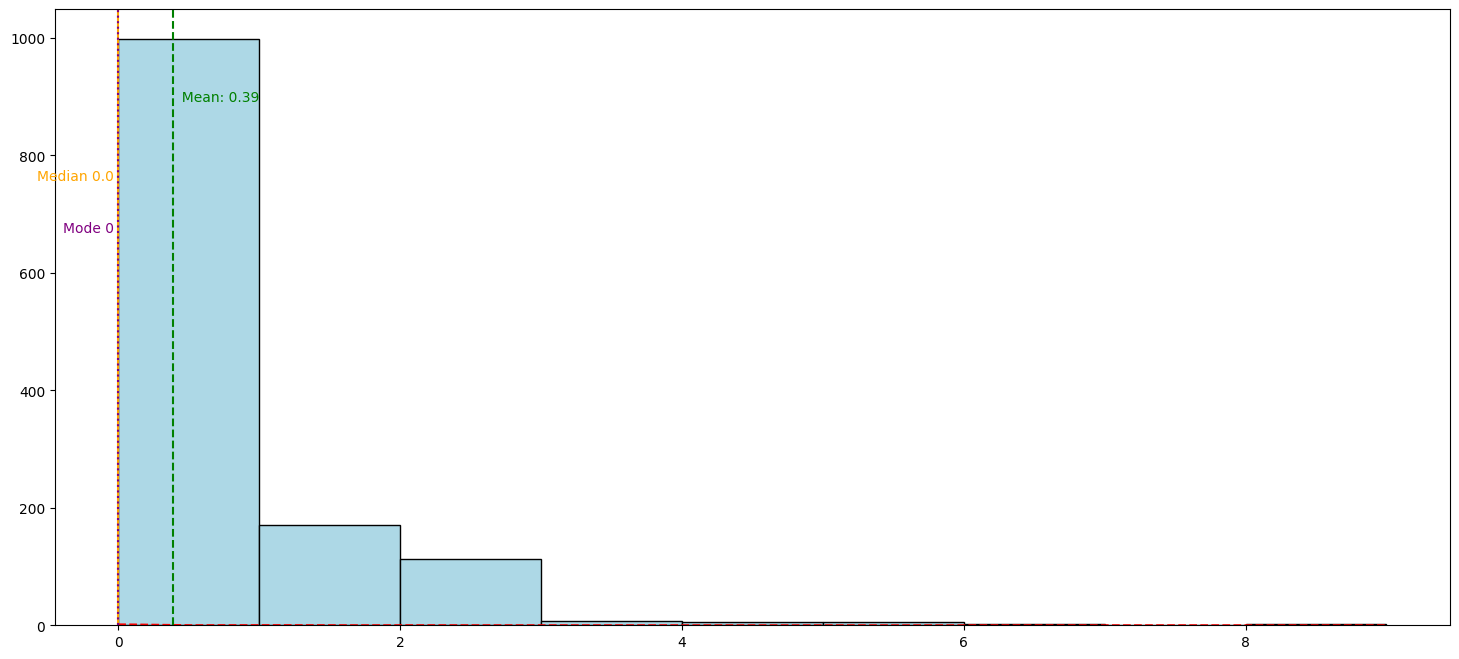

In [45]:
fig, ax = plt.subplots(figsize = (18,8))

# Create Historgram for Number of Parents
ax.hist(df['No of Parents'], bins = 9, color = 'lightblue', edgecolor = 'black', label = 'histogram')

# Overlay a Gaussian KDE
kde = gaussian_kde(df['No of Parents'])
x_vals = np.linspace(min(df['No of Parents']), max(df['No of Parents']), 1000)
y_vals = kde(x_vals)
ax.plot(x_vals, y_vals, color = 'red', linestyle = '--', label='KDE')

y_height = ax.get_ylim()[1] * .85 # used in y values for placing text below

# Overlay Mean, Median, Mode vertical bars and labels
ax.axvline(par_mean, color = 'green', linestyle='--', label='Mean')
ax.text(par_mean, y_height, f'  Mean: {par_mean}', color = 'green', ha='left')

ax.axvline(par_median, color = 'orange', linestyle='-', label='Median')
ax.text(par_median, y_height * .85, f'Median {par_median} ', color = 'orange', ha='right')

ax.axvline(par_mode, color = 'purple', linestyle = ':', label='Mode')
ax.text(par_mode, y_height * .75, f'Mode {par_mode} ', color = 'purple', ha='right')

plt.show()

### **Class:**

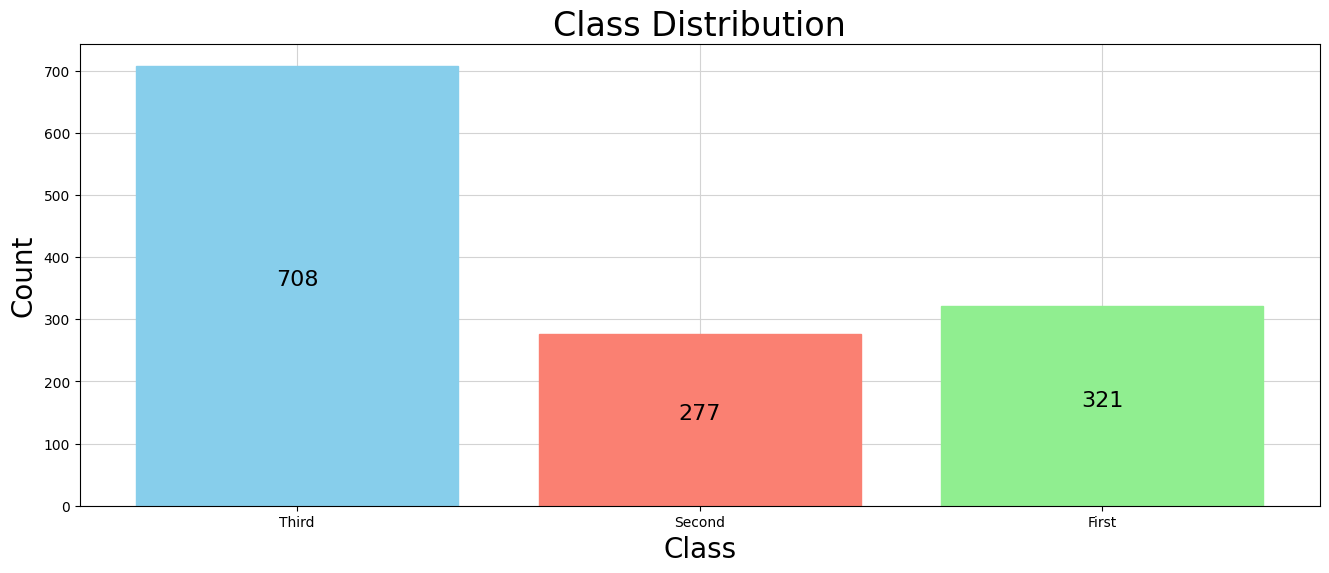

In [47]:
fig, ax = plt.subplots(figsize=(16,6))
counts = df['Class'].value_counts()
custom_order = ['Third', 'Second', 'First']
ordered_counts = counts.reindex(custom_order)

colors = ['skyblue', 'salmon', 'lightgreen']

bars = ax.bar(x=ordered_counts.index.to_list(), height=ordered_counts.values, zorder=2)
ax.grid(color='lightgrey', zorder=1)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    x_pos = bar.get_x() + (bar.get_width() / 2)
    y_pos = bar.get_height() / 2
    ax.text(x_pos, y_pos, f'{ordered_counts.iloc[i]}', color='black', fontsize=16, ha='center')


plt.title('Class Distribution', fontsize=24)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)

plt.show()

In [48]:
proportions = [round(x / len(df),4)*100 for x in ordered_counts.values]
for i, proportion in enumerate(proportions):
    print(f'{custom_order[i]} Class Proportion: {proportion}%')

Third Class Proportion: 54.21%
Second Class Proportion: 21.21%
First Class Proportion: 24.58%


### **Gender:**

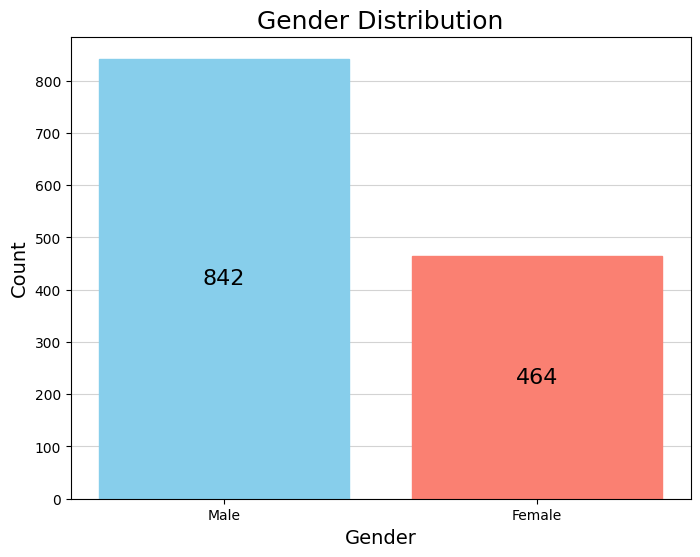

In [49]:
fig, ax = plt.subplots(figsize = (8,6))
ax.grid(color='lightgrey',axis='y',zorder=1)
# get value counts
gender_counts = df['Gender'].value_counts()

bars = ax.bar(x=gender_counts.index.to_list(), height = gender_counts.values,zorder=2)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    x_pos = bar.get_x() + (bar.get_width()/2)
    y_pos = bar.get_height()/2
    ax.text(x_pos,y_pos,f'{gender_counts.values[i]}',fontsize=16,ha='center',va='center')

plt.title('Gender Distribution', fontsize=18)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [50]:
gender_proportions = [round(x/len(df),4)*100 for x in gender_counts.values]
for i,gender_proportion in enumerate(gender_proportions):
    print(f'{gender_counts.index.to_list()[i]} : {gender_proportion}%')

Male : 64.47%
Female : 35.53%


### **Port:**

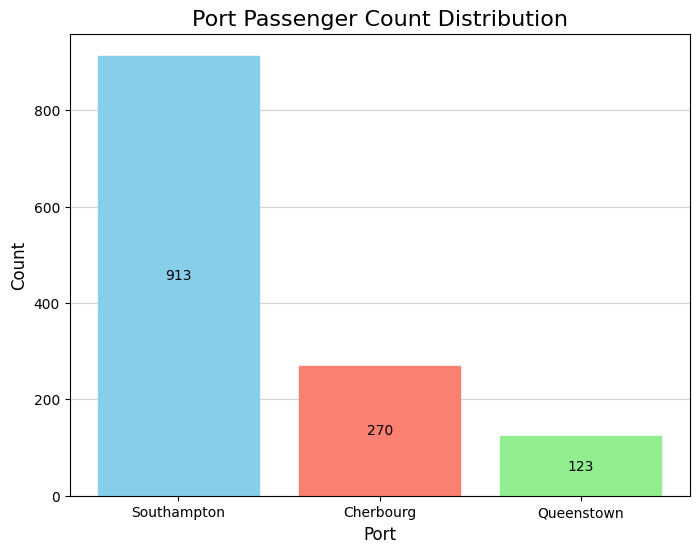

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='lightgrey', axis='y', zorder=1)

port_counts = df['Port'].value_counts()

bars = ax.bar(x=port_counts.index.tolist(), height=port_counts.values, zorder=2)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    x_pos = bar.get_x() + (bar.get_width()/2)
    y_pos = bar.get_height()/2
    ax.text(x_pos, y_pos, f'{port_counts.values[i]}',ha='center',va='center')


plt.title('Port Passenger Count Distribution', fontsize = 16)
plt.xlabel('Port', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [52]:
port_proportions = [round((x/len(df))*100,2) for x in port_counts.values]
for i,proportion in enumerate(port_proportions):
    print(f'{port_counts.index.to_list()[i]}: {proportion}%')

Southampton: 69.91%
Cherbourg: 20.67%
Queenstown: 9.42%


## **Feature Engineering:**

### Family Size

In [53]:
# Family size is the sum of siblings and parents
df['Family Size'] = df['No of Parents'] + df['No of Siblings']

### Age Group

In [75]:
age_bins = [0,12,19,60,100]
age_labels = ['Child', 'Teenager', 'Adult', 'Senior']
df['Age Group'] = pd.cut(x=df['Age'], bins=age_bins, labels=age_labels, right=False)

## **Univariate Analysis on New Features:**

### **Family Size:**

In [57]:
fam_mean = round(df['Family Size'].mean(),2)
fam_median = df['Family Size'].median()
fam_mode = df['Family Size'].mode().iloc[0]
fam_skew = df['Family Size'].skew()
fam_kurt = df['Family Size'].kurt()

print(f'Mean: {fam_mean}')
print(f'Median: {fam_median}')
print(f'Mode: {fam_mode}')
print(f'Skewness: {fam_skew}')
print(f'Kurtosis: {fam_kurt}')

Mean: 0.89
Median: 0.0
Mode: 0
Skewness: 2.849428903587813
Kurtosis: 10.272969769542241


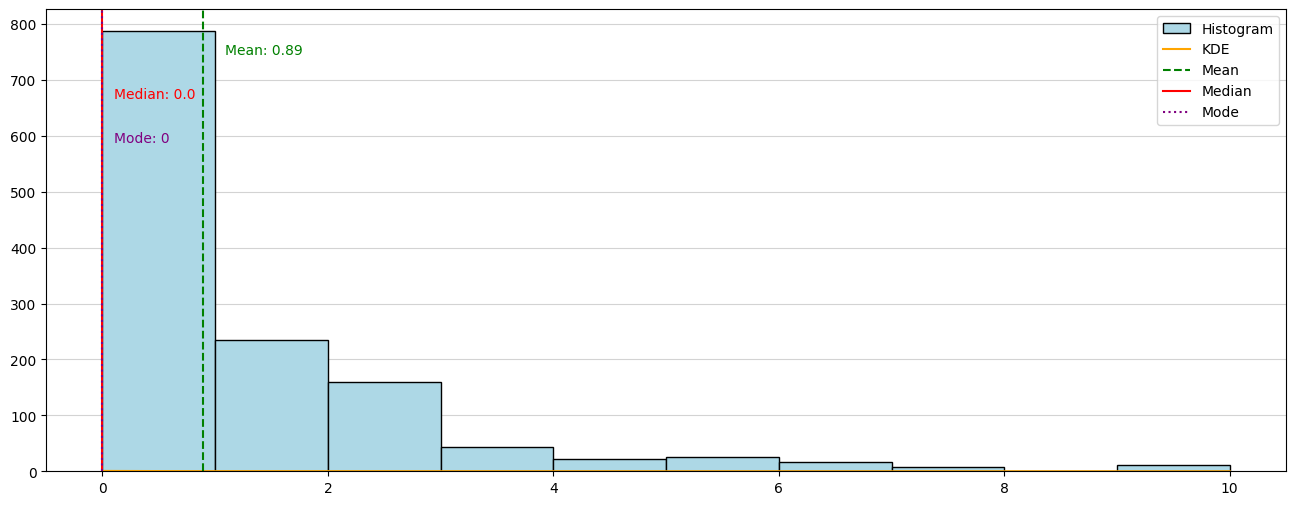

In [68]:
fig, ax = plt.subplots(figsize = (16,6))
ax.grid(color = 'lightgrey', axis='y', zorder=1)

plt.hist(df['Family Size'], bins=10, color='lightblue', edgecolor='black', label='Histogram', zorder=2)

kde = gaussian_kde(df['Family Size'])
x_vals = np.linspace(min(df['Family Size']), max(df['Family Size']), 1000)
y_vals = kde(x_vals)
ax.plot(x_vals, y_vals, color='orange', label='KDE')

y_height = ax.get_ylim()[1] * .95

ax.axvline(fam_mean, color='green', linestyle='--', label='Mean')
ax.axvline(fam_median, color='red', linestyle='-', label='Median')
ax.axvline(fam_mode, color='purple', linestyle=':', label='Mode')

ax.text(fam_mean + 0.2, y_height * .95, f'Mean: {fam_mean}', color='green', ha='left')
ax.text(fam_median + 0.1, y_height * .85, f'Median: {fam_median} ', color='red', ha='left')
ax.text(fam_mode + 0.1, y_height * .75, f'Mode: {fam_mode} ', color='purple', ha='left')

plt.legend()
plt.show()

### **Age Group:**

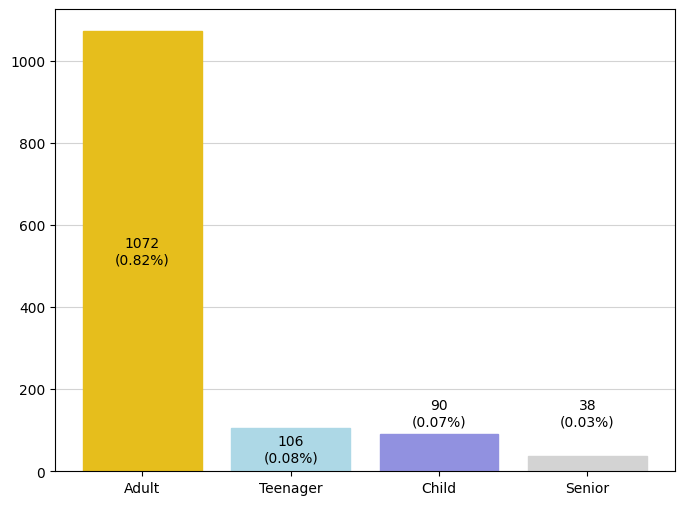

In [102]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='lightgrey', axis='y', zorder=1)

age_group_values = df['Age Group'].value_counts()
colors = ["#E6BE1C", 'lightblue', "#9191E0", 'lightgrey']

bars = plt.bar(x=age_group_values.index.to_list(), height=age_group_values.values, color='lightblue', zorder=2)

proportions = [round(x/len(df),2) for x in age_group_values.values]

for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    y_val = bar.get_height() / 2
    x_val = (bar.get_width() / 2) + bar.get_x()
    if y_val < 50:
        ax.text(x_val,140,f'{bar.get_height()}\n({proportions[i]}%)', ha='center', va='center')
    else:
        ax.text(x_val,y_val,f'{bar.get_height()}\n({proportions[i]}%)', ha='center', va='center')

## Bivariate Analysis

In [ ]:
# Create variables for categorical and numerical features so that they can be looped through below.
numerical_features = df.select_dtypes(include='number')
categorical_features = df.select_dtypes(include='object')

### **Gender V Survived:**

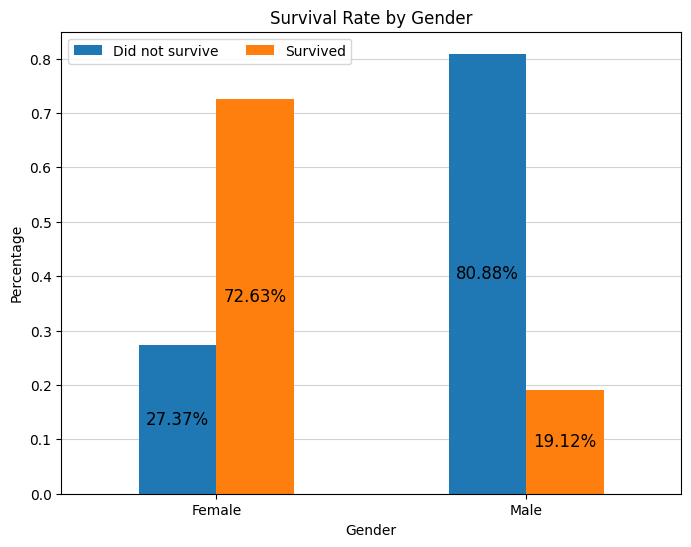

In [ ]:
gender_v_survived_ct = pd.crosstab([df['Gender']], df['Survived'], normalize='index')
ax = gender_v_survived_ct.plot(kind='bar', figsize=(8, 6), rot=0)
ax.grid(color='lightgrey', axis='y', zorder=1)
for container in ax.containers:
    for i, bar in enumerate(container):
        bar.set_zorder(2)
        x = bar.get_width() / 2 + bar.get_x()
        y = bar.get_height() / 2
        ax.text(x,y,f'{round((y*2)*100,2)}%', color='black', fontsize=12, ha='center', va='center')
# Add titles and labels
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.legend(labels=['Did not survive', 'Survived'], loc='upper left', ncols=2)
plt.show()

### **Gender V Numeric Features (as boxplots):**

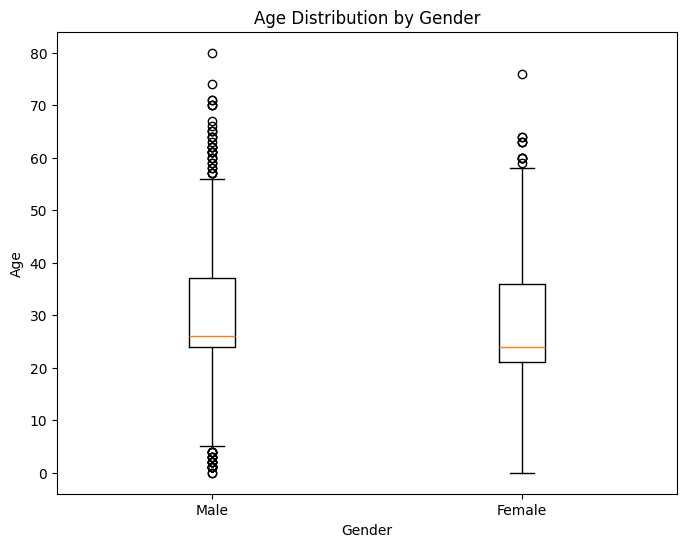

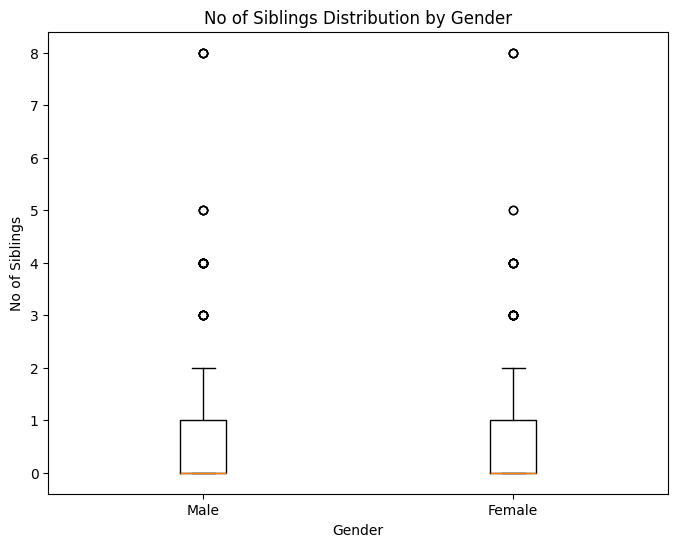

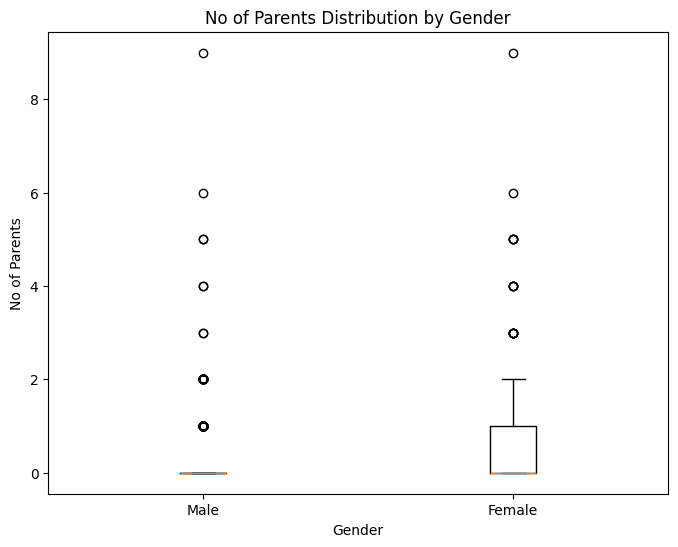

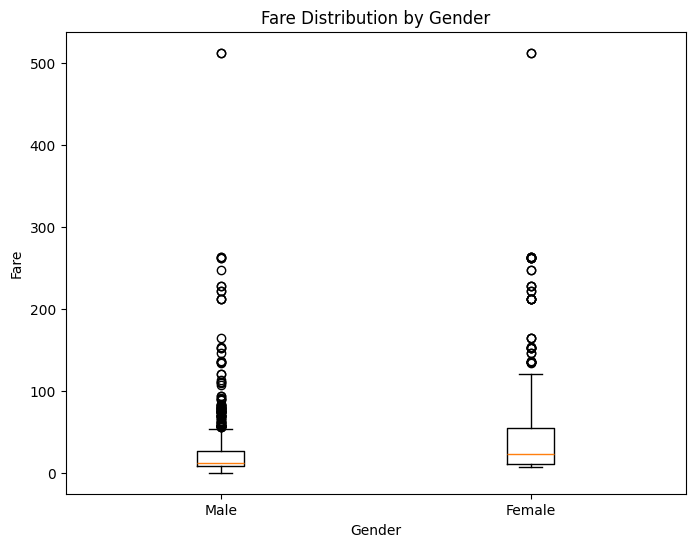

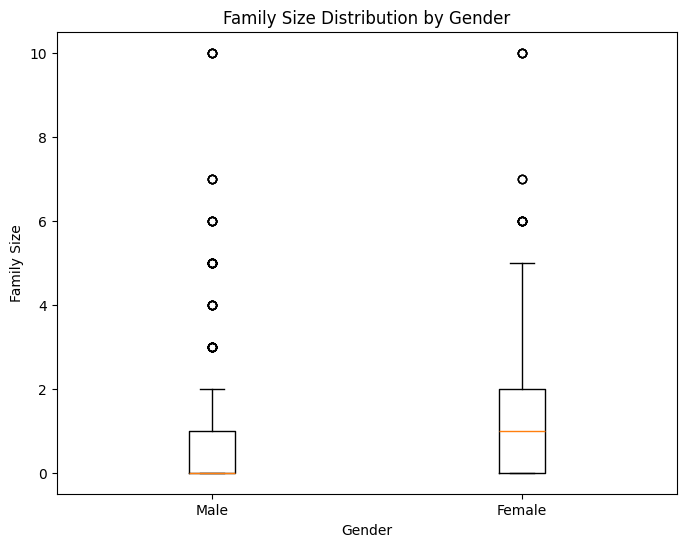

In [189]:
for feature in numerical_features:
    feat_male = df[df['Gender']=='Male'][feature]
    feat_female = df[df['Gender']=='Female'][feature]
    gender_data = [feat_male, feat_female]
    fig, ax = plt.subplots(figsize=(8,6))
    ax.boxplot(gender_data, tick_labels=['Male', 'Female'])
    plt.title(f'{feature} Distribution by Gender')
    plt.xlabel('Gender')
    plt.ylabel(f'{feature}')
    plt.show()

### **Survival Rates by Class:**

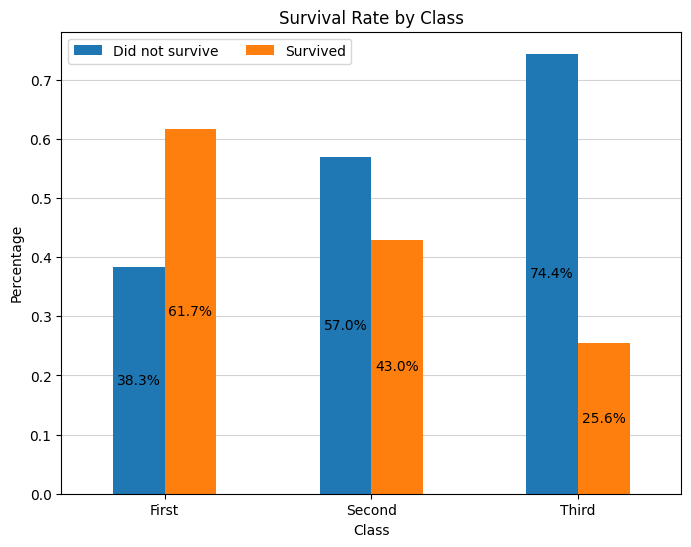

In [ ]:
class_ct = pd.crosstab([df['Class']], df['Survived'], normalize='index')
ax = class_ct.plot(kind='bar', figsize=(8,6), rot=0)
ax.grid(color='lightgrey', axis='y', zorder=1)

for container in ax.containers:
    for bar in container:
        bar.set_zorder(2)
        y = bar.get_height() / 2
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, y, f'{round((y*200),1)}%', ha='center', va='center')

plt.title('Survival Rate by Class')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.legend(labels = ['Did not survive', 'Survived'], loc='upper left', ncols=2)
plt.show()

### **Distribution of Numeric Features by Class:**

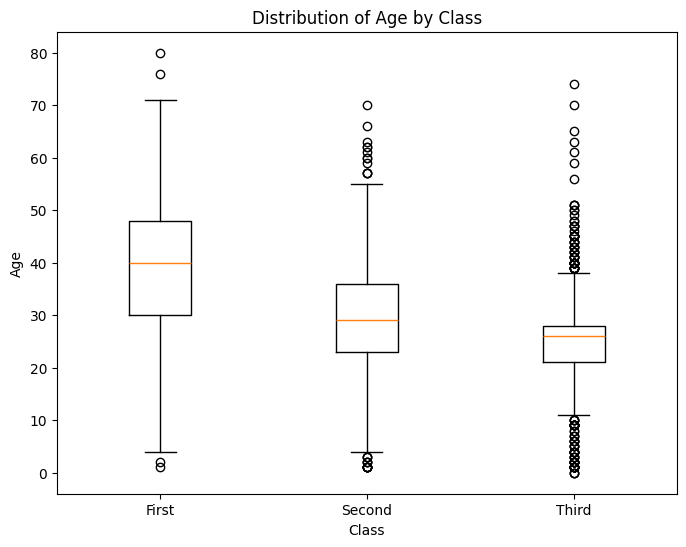

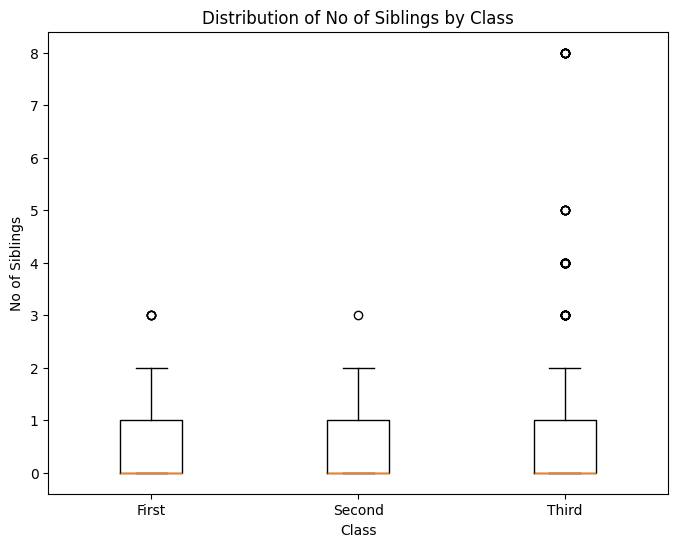

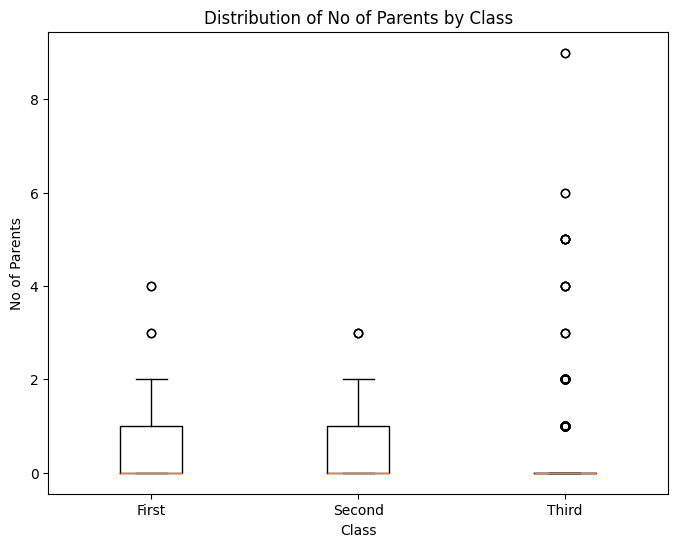

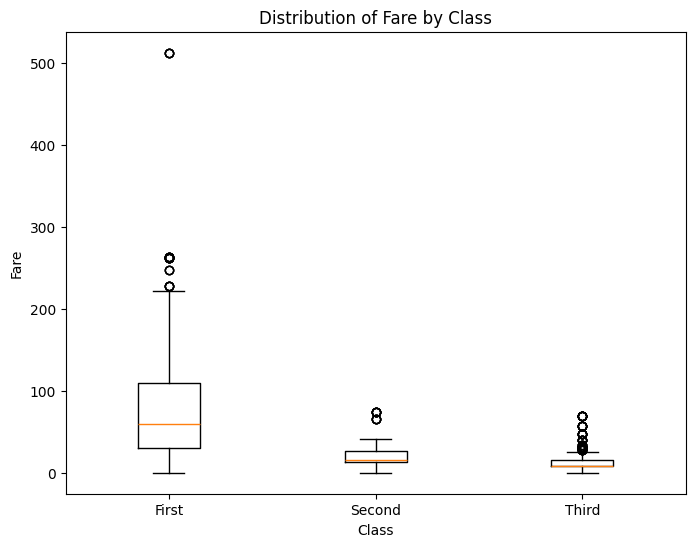

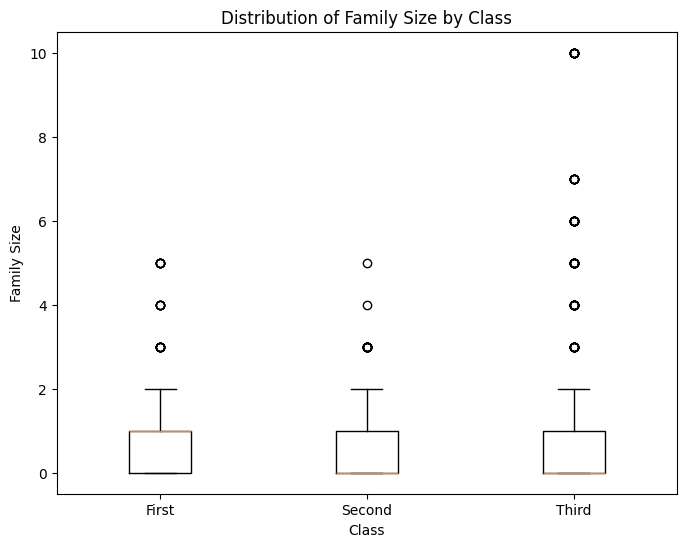

In [207]:
for feature in numerical_features:
    fig, ax = plt.subplots(figsize = (8,6))
    first_class_feat = df[df['Class']=='First'][feature]
    second_class_feat = df[df['Class']=='Second'][feature]
    third_class_feat = df[df['Class']=='Third'][feature]
    class_data = [first_class_feat, second_class_feat, third_class_feat]
    ax.boxplot(class_data, tick_labels=['First', 'Second', 'Third'])
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.show()

### **Survival Rates by Port:**

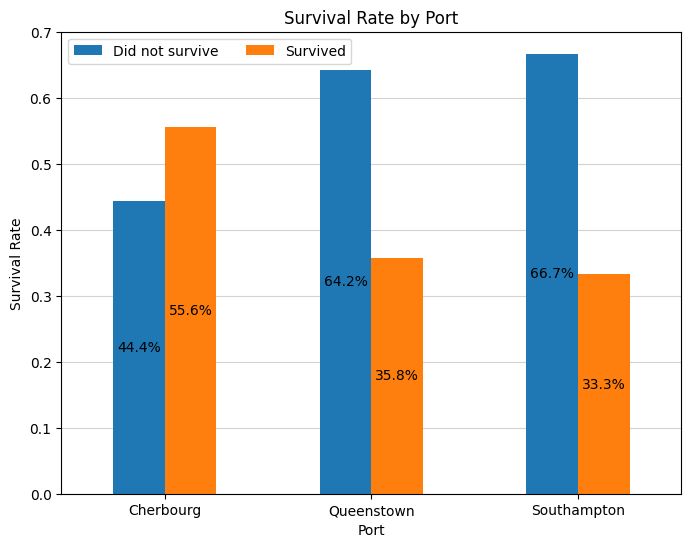

In [ ]:
port_ct = pd.crosstab(df['Port'], df['Survived'], normalize='index')
ax = port_ct.plot(kind='bar', figsize=(8,6), rot=0)
ax.grid(color='lightgrey', axis='y', zorder=1)
for container in ax.containers:
    for bar in container:
        bar.set_zorder(2)
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height() / 2
        ax.text(x,y,f'{round(y*200,1)}%',ha='center',va='center')
plt.title('Survival Rate by Port')
plt.xlabel('Port')
plt.ylabel('Survival Rate')
plt.legend(labels=['Did not survive', 'Survived'], loc='upper left', ncols=2)
plt.show()

### **Distribution of Numeric Features by Port:**

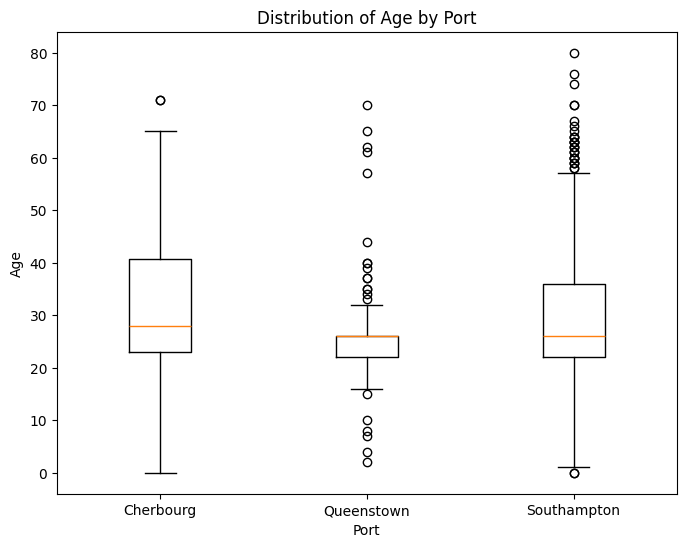

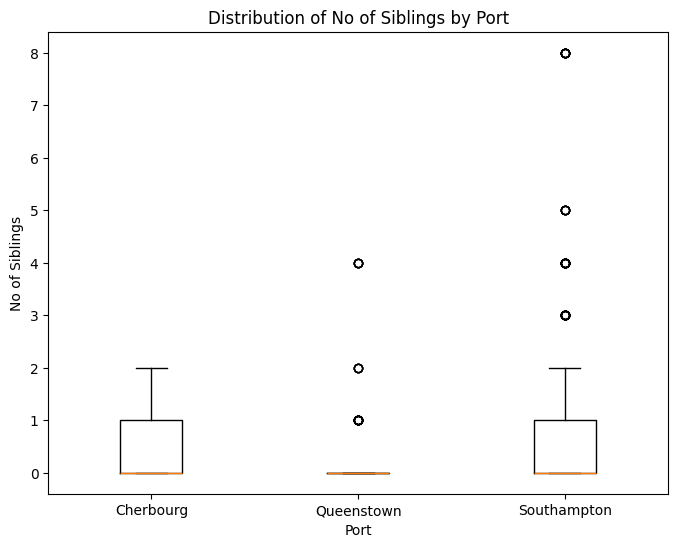

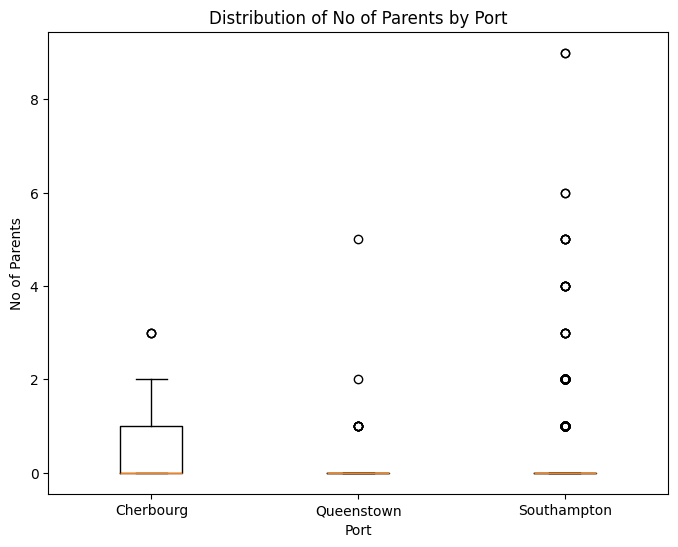

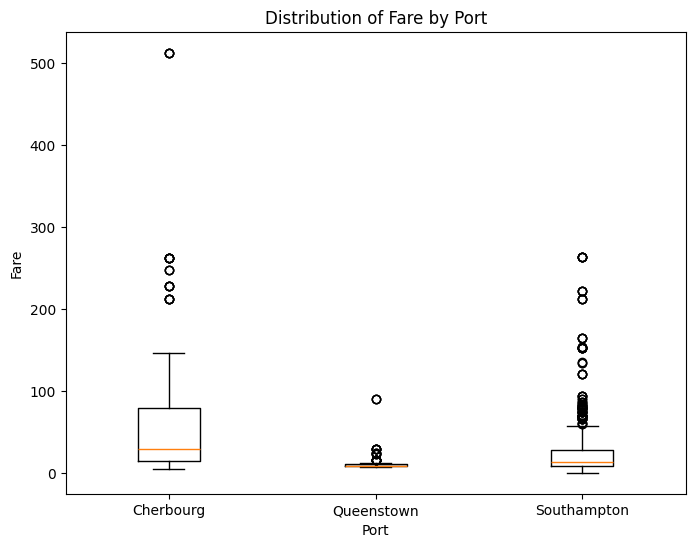

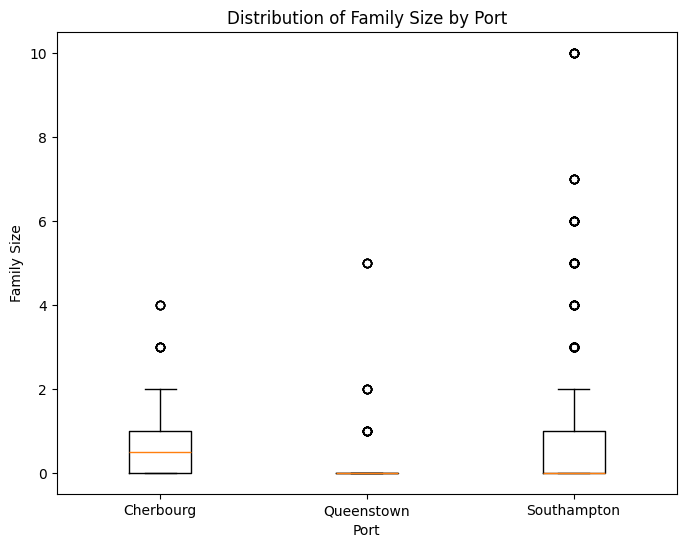

In [212]:
for feature in numerical_features:
    fig, ax = plt.subplots(figsize=(8,6))
    cherbourg_feat = df[df['Port']=='Cherbourg'][feature]
    queenstown_feat = df[df['Port']=='Queenstown'][feature]
    southampton_feat = df[df['Port']=='Southampton'][feature]
    port_data = [cherbourg_feat, queenstown_feat, southampton_feat]
    ax.boxplot(port_data, tick_labels=['Cherbourg', 'Queenstown', 'Southampton'])
    plt.title(f'Distribution of {feature} by Port')
    plt.xlabel('Port')
    plt.ylabel(f'{feature}')
    plt.show()

### **Survival Rate by Age Group:**

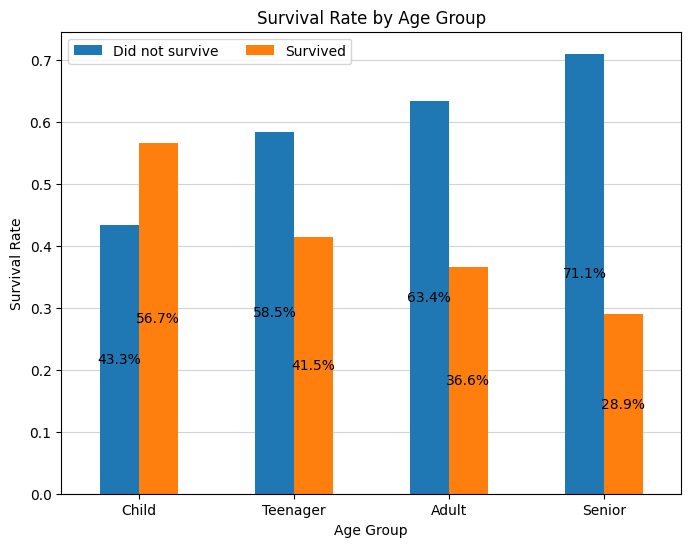

In [ ]:
age_ct = pd.crosstab(df['Age Group'], df['Survived'], normalize='index')
ax = age_ct.plot(kind='bar', figsize=(8,6), rot=0)
ax.grid(color='lightgrey',axis='y',zorder=1)
for container in ax.containers:
    for bar in container:
        bar.set_zorder(2)
        x=bar.get_x()+bar.get_width()/2
        y=bar.get_height() / 2
        ax.text(x,y,f'{round(y*200,1)}%',ha='center',va='center')
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.legend(labels=['Did not survive', 'Survived'], loc='upper left', ncols=2)
plt.show()

### **Distribution of Numerical Features by Age Group:**

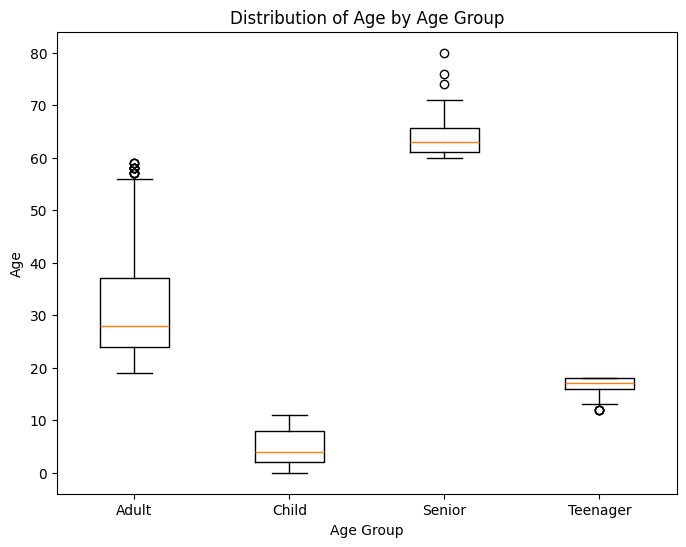

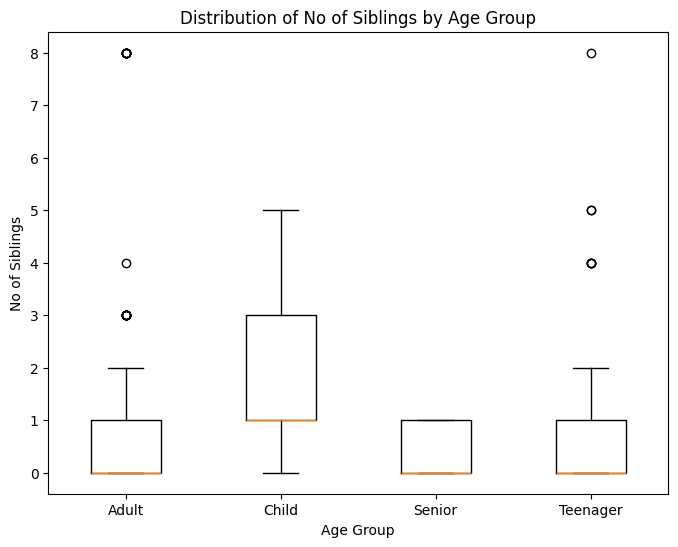

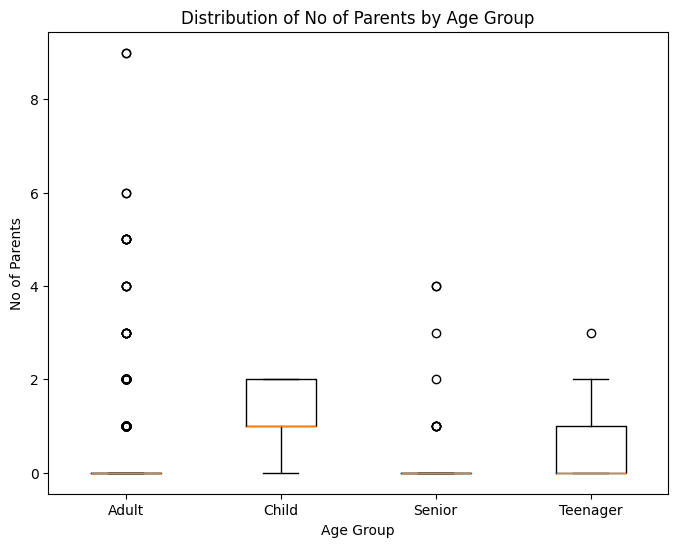

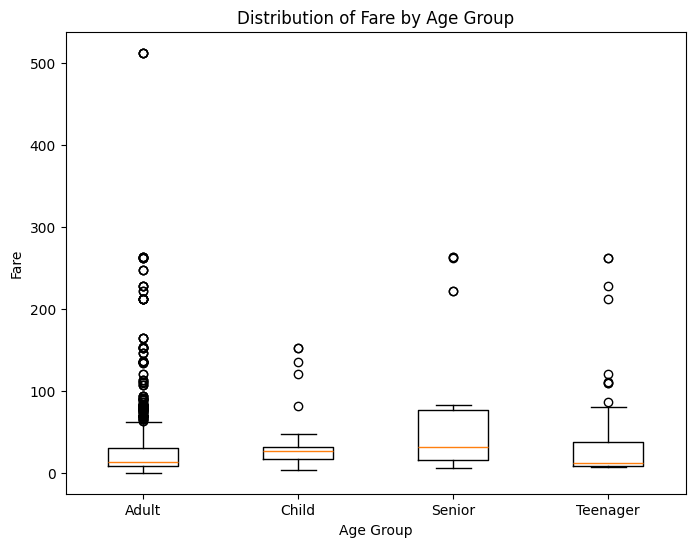

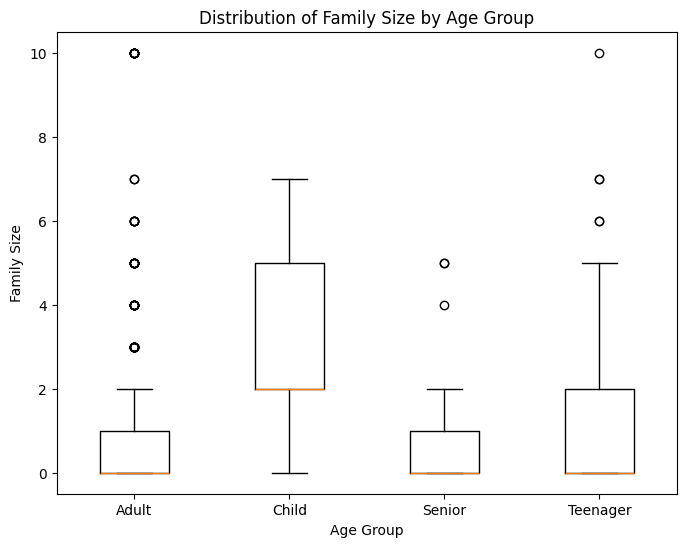

In [223]:
for feature in numerical_features:
    fig, ax = plt.subplots(figsize=(8,6))
    value_data = []
    value_labels = []
    values = df['Age Group'].unique()
    for value in values:
        value_labels.append(value)
        value_data.append(df[df['Age Group'] == value][feature])
    ax.boxplot(value_data, tick_labels=value_labels)
    plt.title(f'Distribution of {feature} by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel(f'{feature}')
    plt.show()


### **Frequency of Categorical Features by Age Group:**

In [226]:
port_ct = pd.crosstab(df['Port'], df['Age Group'], normalize='all')
print(port_ct)

Age Group       Child  Teenager     Adult    Senior
Port                                               
Cherbourg    0.011485  0.017611  0.170750  0.006891
Queenstown   0.003828  0.005360  0.081930  0.003063
Southampton  0.053599  0.058193  0.568147  0.019142


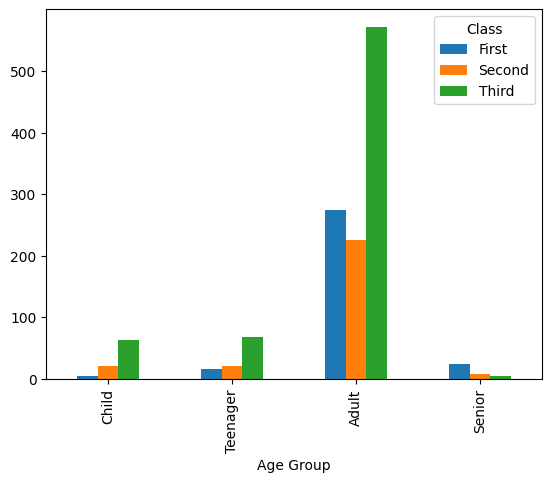

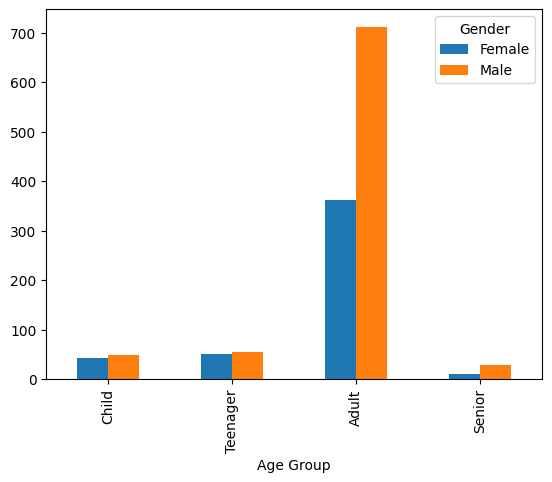

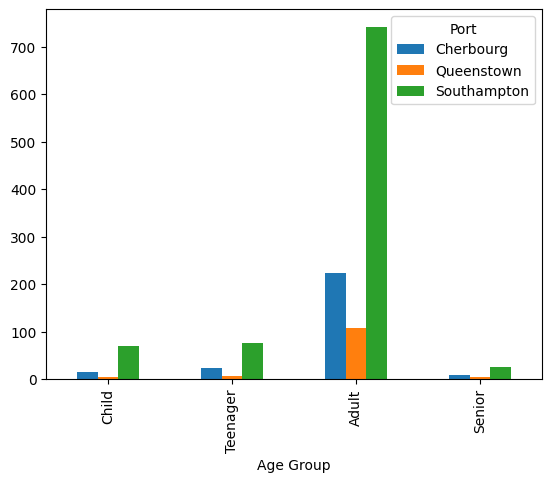

In [234]:
target = 'Age Group'
for feature in categorical_features:
    if (feature == target) | (feature in ['Name', 'Ticket Number', 'Survived']):
        continue
    else:
        target_ct = pd.crosstab(df[target], df[feature])
        ax = target_ct.plot(kind='bar')

## **Appendix:**

### **Distribution of Numeric Features by Categorical Features:**

In [ ]:
for cat_feat in categorical_features:
    if cat_feat in ['Name', 'Ticket Number']:
        continue
    else:
        for num_feat in numerical_features:
            values = df[cat_feat].unique()
            value_labels = []
            values_data = []
            for value in values:
                value_labels.append(value)
                values_data.append(df[df[cat_feat] == value][num_feat])
            fig, ax = plt.subplots(figsize=(8,6))
            ax.boxplot(values_data, tick_labels=value_labels)
            plt.title(f'Distribution of {num_feat} by {cat_feat}')
            plt.xlabel(f'{cat_feat}')
            plt.ylabel(f'{num_feat}')
            plt.show()